Trying to come up with some metrics to detect overflow.

In [39]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

In [94]:
data = pd.read_csv('consolidated.csv')

In [95]:
# This is the time in seconds taken to complete a call(included post-processing).
data['Avg-time'] = data['Avg-time'].fillna(0) 

In [96]:
data['lambda'] = data['ncalls'].rolling(window=6).mean() # Number of calls per 5 minutes.

In [97]:
data.set_index('Create-time', inplace=True)

In [99]:
data['mu'] = data['Avg-time']/300 # The term lambda/mu must be unit less.

In [100]:
data['E'] = data['lambda']*data['mu'] # Ordered traffic in erlangs

**Question:**
Given a number of agents, average time to complete a task and rate the incoming calls what is the average waiting time?

The number of agents on a day is known. We should be able to plot another curve on this chart which indicates the maximum inflow we can sustain without dropping quality. That should give our first indication of things slipping out of control. In fact, we can add yet another curve that indicates that we are approaching danger.

One may not be able to infer the queue length as easily as forecast ASA. I think the business tracks ASA and not the queue length. Refer to equation (1.4) in the paper 'Evaluating the Erlang C and Erlang A Models for Call Center Modeling'. File name is 'Erlang Compare Working paper.pdf'.


In [133]:
def factorial(n):
    if n == 0:
        return 1.0
    else:
        f = 1.0
        for m in range(1, n+1):
            f = f * m
        
        return f
    
def prob_of_wait(ncalls, E, m, drop=40):
    """
    ncalls: number of calls in an interval of 5 minutes.
    E:      traffic
    m:      # agents.
    drop:   a variable that corrects the number of people on the floor. 
    Reference: https://en.wikipedia.org/wiki/Erlang_(unit)
    """
    if ncalls == 0:
        return 0
    
    # Remove this block. This is just an experiment.    
    if m > drop + 1 and m - E != drop:
        m -= drop
    
    numerator = E**m/factorial(m) * m/(m-E)
    denominator = 0
        
    for i in range(m):
        denominator += E**i/factorial(i)
        
    denominator += numerator
    
    p = numerator/denominator
    
    # TODO: Find out when p exceeds 1. Which assumptions of Erlang C formula are violated?
    if p > 1:
        p = 1
        
    return p

def calculate_ASA(wait_prob, N, mu, rho):
    return wait_prob/(N * mu * rho)

In [134]:
assert factorial(0) == 1
assert factorial(1) == 1
assert factorial(5) == 120
assert factorial(12) == 479001600

In [135]:
prob_of_wait(17, 25.738519, 76)

0.037587062946995514

In [136]:
r = data.loc['2020-07-20 10:35:00']
prob_of_wait(r['ncalls'], r['E'], r['nagents'])

1

In [ ]:
drop = 20 # The number by which the agent count should be reduced.

In [137]:
data['wait-prob'] = data.apply(lambda r: prob_of_wait(r['ncalls'], r['E'], r['nagents'], drop), axis=1)

In [138]:
data['asa'] = data['wait-prob'] * data['mu']/(data['nagents'] - E - drop) * 5 # Convert to minutes

In [139]:
data.loc['2020-07-20 09:35:00':'2020-07-20 10:35:00']

,ncalls,Avg-time,Period,nagents,lambda,mu,E,wait-prob,asa
Create-time,,,,,,,,,
2020-07-20 09:35:00,19,380.526316,2020-07-20,76,20.333333,1.268421,25.791228,1.809803e-07,2.133979e-08
2020-07-20 09:40:00,8,390.500000,2020-07-20,76,17.666667,1.301667,22.996111,4.398619e-09,5.322448e-10
2020-07-20 09:45:00,30,473.133333,2020-07-20,76,18.333333,1.577111,28.913704,5.349538e-06,7.842850e-07
2020-07-20 09:50:00,17,649.647059,2020-07-20,76,18.500000,2.165490,40.061569,1.115810e-02,2.246165e-03
2020-07-20 09:55:00,28,491.750000,2020-07-20,76,19.000000,1.639167,31.144167,4.020189e-05,6.125830e-06
2020-07-20 10:00:00,25,386.520000,2020-07-20,76,21.166667,1.288400,27.271133,9.855451e-07,1.180382e-07
2020-07-20 10:05:00,17,564.470588,2020-07-20,76,20.833333,1.881569,39.199346,7.416984e-03,1.297307e-03
2020-07-20 10:10:00,22,506.090909,2020-07-20,76,23.166667,1.686970,39.081465,7.001004e-03,1.097901e-03
2020-07-20 10:15:00,29,572.000000,2020-07-20,76,23.000000,1.906667,43.853333,5.186597e-02,9.192901e-03


In [140]:
data.to_csv('wait_prob.csv', index=False)

In [130]:
np.max(data['wait-prob'])

1.0

<AxesSubplot:>

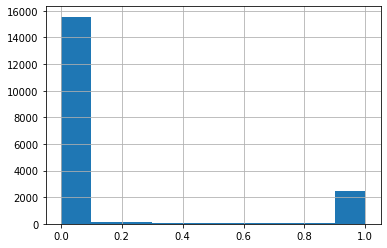

In [131]:
data['wait-prob'].hist()

In [132]:
np.max(data['E'])

215.23868686868684

**19-Oct-2020**

I implemented a function to compute the probability that a customer will have to wait. Since I do not have accurate data on the number of agents on the floor and I believe that perhaps 76 is a very large number, I reduced it by 40. This is also to check if there are situations when the probability of wait is one. I also calculate the ASA for each interval of five minutes.

Next steps:
1. Get an accurate count of agents on the floor for every interval of 5 minutes.
2. Confirm that that situation was indeed read when probability of wait exceeded 0.5.